In [54]:
import sympy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Derivatives for the self-measurement observation model wrt the state vector for one agent

In [55]:
def h(x_vec):
    o = 3
    p_vec = x_vec[:o]
    fun = p_vec
    return fun

def Dh(x_vec):
    o = 3
    n = len(x_vec)
    first_order_pder = np.zeros((o, n))
    first_order_pder[:o, :o] = np.eye(o)
    return first_order_pder

def Hh(x_vec):
    o = 3
    n = len(x_vec)
    return np.kron(np.ones((n, 1)), np.zeros((o, n)))

In [56]:
o = 3
n = 6
p1, p2, p3, v1, v2, v3 = sp.symbols('p1 p2 p3 v1 v2 v3')
p_vec = sp.Matrix([p1, p2, p3])
x_vec = sp.Matrix([p1, p2, p3, v1, v2, v3])
fun = p_vec
first_order_der = fun.jacobian(x_vec)
first_order_der_fun = sp.lambdify(x_vec, sp.ImmutableDenseNDimArray(first_order_der).tolist(), 'numpy')
second_order_der = sp.Matrix(np.array(sp.derive_by_array(first_order_der, x_vec)).reshape((o*n, n)))
second_order_der_fun = sp.lambdify(x_vec, sp.ImmutableDenseNDimArray(second_order_der).tolist(), 'numpy')

# Example point
std = 1e0
sample_x_vec = np.random.multivariate_normal(mean=np.zeros(n,), cov=std*np.eye(n)).reshape((n, 1))

# First Order Partial Derivatives Comparison
first_order_partial_derivatives_symbolic = np.array(first_order_der_fun(*sample_x_vec.flatten()))
first_order_partial_derivatives_analytical = Dh(sample_x_vec)
print(np.allclose(first_order_partial_derivatives_analytical, first_order_partial_derivatives_symbolic, atol=1e-6))

# Second Order Partial Derivatives Comparison
second_order_partial_derivatives_symbolic = np.array(second_order_der_fun(*sample_x_vec.flatten()))
second_order_partial_derivatives_analytical = Hh(sample_x_vec)
print(np.allclose(second_order_partial_derivatives_analytical, second_order_partial_derivatives_symbolic, atol=1e-6))

M = 100
all_close_results = []
for _ in range(M):
    sample_x_vec = np.random.multivariate_normal(mean=np.zeros(n,), cov=std*np.eye(n)).reshape((n, 1))
    first_order_partial_derivatives_symbolic = np.array(first_order_der_fun(*sample_x_vec.flatten()))
    first_order_partial_derivatives_analytical = Dh(sample_x_vec)
    second_order_partial_derivatives_symbolic = np.array(second_order_der_fun(*sample_x_vec.flatten()))
    second_order_partial_derivatives_analytical = Hh(sample_x_vec)
    all_close = np.allclose(first_order_partial_derivatives_analytical, first_order_partial_derivatives_symbolic, atol=1e-6) and np.allclose(second_order_partial_derivatives_analytical, second_order_partial_derivatives_symbolic, atol=1e-6)
    all_close_results.append(all_close)
print(f"All Cases Passed?: {all(all_close_results)}")

True
True
All Cases Passed?: True


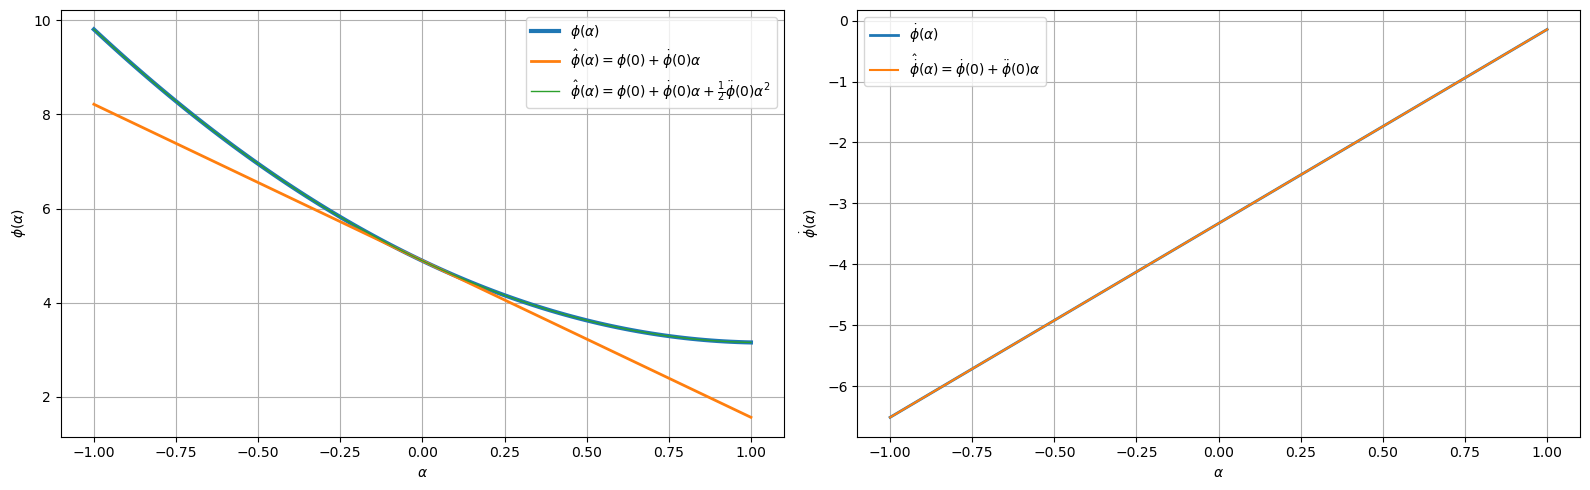

In [57]:
def test_function(p, alpha, x_vec):
    cost = h(p + alpha * x_vec)
    return 1 / 2 * np.linalg.norm(cost)**2

def test_function_grad(p, alpha, x_vec):
    cost = h(p + alpha * x_vec)
    jacobian = Dh(p + alpha * x_vec)
    return cost.T @ jacobian @ x_vec

def test_function_hessian(p, alpha, x_vec):
    o = 3
    n = len(x_vec)
    cost = h(p + alpha * x_vec)
    jacobian = Dh(p + alpha * x_vec)
    hessian = Hh(p + alpha * x_vec)
    # return cost.T @ np.einsum('ijk,k->ij', hessian.reshape((n, o, n)), x_vec.flatten()).T @ x_vec + x_vec.T @ jacobian.T @ jacobian @ x_vec # Which is also the same
    return cost.T @ np.kron(x_vec, np.eye(o)).T @ hessian @ x_vec + x_vec.T @ jacobian.T @ jacobian @ x_vec

def test_function_approx_first_order(p, alpha, x_vec):
    return test_function(p, 0, x_vec) + test_function_grad(p, 0, x_vec) * alpha

def test_function_approx_second_order(p, alpha, x_vec):
    return test_function(p, 0, x_vec) + test_function_grad(p, 0, x_vec) * alpha + 1/2 * test_function_hessian(p, 0, x_vec) * alpha**2

def test_function_grad_approx_first_order(p, alpha, x_vec):
    return test_function_grad(p, 0, x_vec) + test_function_hessian(p, 0, x_vec) * alpha

std = 1e0
sample_p_vec = np.random.multivariate_normal(mean=np.zeros(3,), cov=std*np.eye(3)).reshape((3, 1))
p = np.random.multivariate_normal(mean=np.zeros(3,), cov=std*np.eye(3)).reshape((3, 1))

aux = 1e0
alpha_bounds = np.linspace(-aux, aux, 100)
cost_values = np.array([test_function(p, alpha, sample_p_vec).flatten() for alpha in alpha_bounds])
gradient_values = np.array([test_function_grad(p, alpha, sample_p_vec).flatten() for alpha in alpha_bounds])
hessian_values = np.array([test_function_hessian(p, alpha, sample_p_vec).flatten() for alpha in alpha_bounds])
taylor_series_first_order_expansion_test_function = np.array([test_function_approx_first_order(p, alpha, sample_p_vec).flatten() for alpha in alpha_bounds])
taylor_series_second_order_expansion_test_function = np.array([test_function_approx_second_order(p, alpha, sample_p_vec).flatten() for alpha in alpha_bounds])
taylor_series_first_order_expansion_test_function_grad = np.array([test_function_grad_approx_first_order(p, alpha, sample_p_vec).flatten() for alpha in alpha_bounds])

# Arrows arrows
num_arrows = 30
arrow_indices = np.linspace(0, len(alpha_bounds) - 1, num_arrows, dtype=int)

def compute_tangent_slope(x, y, idx):
    """Compute the slope of the tangent line at a given index idx."""
    if idx == 0:
        slope = (y[idx + 1] - y[idx]) / (x[idx + 1] - x[idx])
    elif idx == len(x) - 1:
        slope = (y[idx] - y[idx - 1]) / (x[idx] - x[idx - 1])
    else:
        slope = (y[idx + 1] - y[idx - 1]) / (x[idx + 1] - x[idx - 1])

    return slope

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Left plot: Function and gradient arrows
axes[0].plot(alpha_bounds, cost_values, label=r'$\phi(\alpha)$', linewidth=3)
# axes[0].quiver(alpha_bounds[arrow_indices], cost_values[arrow_indices], 
#                np.ones_like(arrow_indices), gradient_values[arrow_indices], 
#                angles='xy', scale_units='xy', color='red', width=0.004, zorder=2, label=r'Analytical $\dot{\phi}(\alpha)$')
# axes[0].quiver(alpha_bounds[arrow_indices][1:], cost_values[arrow_indices][1:],
#                 np.ones_like(arrow_indices[1:]), np.array([compute_tangent_slope(alpha_bounds, cost_values, idx) for idx in arrow_indices])[1:],
#                 angles="xy", scale_units="xy", color="black", width=0.005, label=r'Numerical $\dot{\phi}(\alpha)$')
axes[0].plot(alpha_bounds, taylor_series_first_order_expansion_test_function, label=r'$\hat{\phi}(\alpha) = \phi(0) + \dot{\phi}(0)\alpha$', zorder=3, linewidth=2)
axes[0].plot(alpha_bounds, taylor_series_second_order_expansion_test_function, label=r'$\hat{\phi}(\alpha) = \phi(0) + \dot{\phi}(0)\alpha + \frac{1}{2}\ddot{\phi}(0)\alpha^2$', zorder=3, linewidth=1)
axes[0].set_xlabel(r'$\alpha$')
axes[0].set_ylabel(r'$\phi(\alpha)$')
axes[0].grid()
axes[0].legend()

# Right plot: Gradient and Hessian arrows
axes[1].plot(alpha_bounds, gradient_values, label=r'$\dot{\phi}(\alpha)$', linewidth=2)
# axes[1].quiver(alpha_bounds[arrow_indices], gradient_values[arrow_indices], 
#                np.ones_like(arrow_indices), hessian_values[arrow_indices], 
#                angles='xy', scale_units='xy', color='red', width=0.004, zorder=2, label=r'Analytical $\ddot{\phi}(\alpha)$')
# axes[1].quiver(alpha_bounds[arrow_indices][1:], gradient_values[arrow_indices][1:], 
#                np.ones_like(arrow_indices[1:]), np.array([compute_tangent_slope(alpha_bounds, gradient_values, idx) for idx in arrow_indices])[1:], 
#                angles="xy", scale_units="xy", color="black", width=0.005, label=r'Numerical $\ddot{\phi}(\alpha)$')
axes[1].plot(alpha_bounds, taylor_series_first_order_expansion_test_function_grad, label=r'$\hat{\dot{\phi}}(\alpha) = \dot{\phi}(0) + \ddot{\phi}(0)\alpha$', zorder=3)
axes[1].set_xlabel(r'$\alpha$')
axes[1].set_ylabel(r'$\dot{\phi}(\alpha)$')
axes[1].grid()
axes[1].legend()

plt.tight_layout()

### Derivatives for the observation model wrt the total state vector

In [58]:
def h(x_vec):
    p_vec_1 = x_vec[:3]
    p_vec_2 = x_vec[6:9]
    p_vec_3 = x_vec[12:15]
    p_vec_4 = x_vec[18:21]
    
    d_21 = p_vec_2 - p_vec_1
    d_23 = p_vec_2 - p_vec_3
    d_24 = p_vec_2 - p_vec_4
    d_31 = p_vec_3 - p_vec_1
    d_34 = p_vec_3 - p_vec_4
    d_41 = p_vec_4 - p_vec_1
    
    norm_21 = np.linalg.norm(d_21)
    norm_23 = np.linalg.norm(d_23)
    norm_24 = np.linalg.norm(d_24)
    norm_31 = np.linalg.norm(d_31)
    norm_34 = np.linalg.norm(d_34)
    norm_41 = np.linalg.norm(d_41)
    
    return np.concatenate((p_vec_1, np.array([[norm_21], [norm_23], [norm_24], [norm_31], [norm_34], [norm_41]])))

def Dh(x_vec):
    o = 9
    n = len(x_vec)
    first_order_der = np.zeros((o, n))
    
    p_vec_1 = x_vec[:3]
    p_vec_2 = x_vec[6:9]
    p_vec_3 = x_vec[12:15]
    p_vec_4 = x_vec[18:21]
    
    d_21 = p_vec_2 - p_vec_1
    d_23 = p_vec_2 - p_vec_3
    d_24 = p_vec_2 - p_vec_4
    d_31 = p_vec_3 - p_vec_1
    d_34 = p_vec_3 - p_vec_4
    d_41 = p_vec_4 - p_vec_1
    
    norm_21 = np.linalg.norm(d_21)
    norm_23 = np.linalg.norm(d_23)
    norm_24 = np.linalg.norm(d_24)
    norm_31 = np.linalg.norm(d_31)
    norm_34 = np.linalg.norm(d_34)
    norm_41 = np.linalg.norm(d_41)
    
    first_order_der[:3, :3] = np.eye(3)
    first_order_der[3, 0:3] = -d_21.T / norm_21
    first_order_der[3, 6:9] = d_21.T / norm_21
    first_order_der[4, 6:9] = d_23.T / norm_23
    first_order_der[4, 12:15] = -d_23.T / norm_23
    first_order_der[5, 6:9] = d_24.T / norm_24
    first_order_der[5, 18:21] = -d_24.T / norm_24
    first_order_der[6, 0:3] = -d_31.T / norm_31
    first_order_der[6, 12:15] = d_31.T / norm_31
    first_order_der[7, 12:15] = d_34.T / norm_34
    first_order_der[7, 18:21] = -d_34.T / norm_34
    first_order_der[8, 0:3] = -d_41.T / norm_41
    first_order_der[8, 18:21] = d_41.T / norm_41
    
    return first_order_der

def Hh(x_vec):
    o = 9
    n = len(x_vec)
    second_order_der = np.zeros((o, n, n))
    
    p_vec_1 = x_vec[:3]
    p_vec_2 = x_vec[6:9]
    p_vec_3 = x_vec[12:15]
    p_vec_4 = x_vec[18:21]
    
    d_21 = p_vec_2 - p_vec_1
    d_23 = p_vec_2 - p_vec_3
    d_24 = p_vec_2 - p_vec_4
    d_31 = p_vec_3 - p_vec_1
    d_34 = p_vec_3 - p_vec_4
    d_41 = p_vec_4 - p_vec_1
    
    norm_21 = np.linalg.norm(d_21)
    norm_23 = np.linalg.norm(d_23)
    norm_24 = np.linalg.norm(d_24)
    norm_31 = np.linalg.norm(d_31)
    norm_34 = np.linalg.norm(d_34)
    norm_41 = np.linalg.norm(d_41)
    
    def hessian_distance(d_vec, norm_d):
        I = np.eye(3)
        return -(I / norm_d - np.outer(d_vec, d_vec) / norm_d**3)

    # Assign second-order derivatives correctly within the tensor
    second_order_der[3, :3, :3] = -hessian_distance(d_21, norm_21)
    second_order_der[3, :3, 6:9] = hessian_distance(d_21, norm_21)
    second_order_der[3, 6:9, :3] = hessian_distance(d_21, norm_21)
    second_order_der[3, 6:9, 6:9] = -hessian_distance(d_21, norm_21)

    second_order_der[4, 6:9, 6:9] = -hessian_distance(d_23, norm_23)
    second_order_der[4, 6:9, 12:15] = hessian_distance(d_23, norm_23)
    second_order_der[4, 12:15, 6:9] = hessian_distance(d_23, norm_23)
    second_order_der[4, 12:15, 12:15] = -hessian_distance(d_23, norm_23)

    second_order_der[5, 6:9, 6:9] = -hessian_distance(d_24, norm_24)
    second_order_der[5, 6:9, 18:21] = hessian_distance(d_24, norm_24)
    second_order_der[5, 18:21, 6:9] = hessian_distance(d_24, norm_24)
    second_order_der[5, 18:21, 18:21] = -hessian_distance(d_24, norm_24)

    second_order_der[6, :3, :3] = -hessian_distance(d_31, norm_31)
    second_order_der[6, :3, 12:15] = hessian_distance(d_31, norm_31)
    second_order_der[6, 12:15, :3] = hessian_distance(d_31, norm_31)
    second_order_der[6, 12:15, 12:15] = -hessian_distance(d_31, norm_31)

    second_order_der[7, 12:15, 12:15] = -hessian_distance(d_34, norm_34)
    second_order_der[7, 12:15, 18:21] = hessian_distance(d_34, norm_34)
    second_order_der[7, 18:21, 12:15] = hessian_distance(d_34, norm_34)
    second_order_der[7, 18:21, 18:21] = -hessian_distance(d_34, norm_34)

    second_order_der[8, :3, :3] = -hessian_distance(d_41, norm_41)
    second_order_der[8, :3, 18:21] = hessian_distance(d_41, norm_41)
    second_order_der[8, 18:21, :3] = hessian_distance(d_41, norm_41)
    second_order_der[8, 18:21, 18:21] = -hessian_distance(d_41, norm_41)
    
    return second_order_der.reshape((o * n, n))

In [59]:
def h(x_vec):
    n = len(x_vec)
    p_vecs = [x_vec[i:i+3] for i in range(0, n, 6)]
    distances = [np.linalg.norm(p_vecs[j] - p_vecs[i]) for (i, j) in [(1, 0), (1, 2), (1, 3), (2, 0), (2, 3), (3, 0)]]
    return np.concatenate((p_vecs[0], np.array(distances).reshape(-1, 1)))

def Dh(x_vec):
    o, n = 9, len(x_vec)
    first_order_der = np.zeros((o, n))
    p_vecs = [x_vec[i:i+3] for i in range(0, n, 6)]
    
    first_order_der[:3, :3] = np.eye(3)
    
    for k, (i, j) in enumerate([(1, 0), (1, 2), (1, 3), (2, 0), (2, 3), (3, 0)], start=3):
        d = p_vecs[j] - p_vecs[i]
        norm_d = np.linalg.norm(d)
        first_order_der[k, i*6:i*6+3] = -d.T / norm_d
        first_order_der[k, j*6:j*6+3] = d.T / norm_d
    
    return first_order_der

def Hh(x_vec):
    o, n = 9, len(x_vec)
    second_order_der = np.zeros((o, n, n))
    p_vecs = [x_vec[i:i+3] for i in range(0, n, 6)]

    def hessian_distance(d, norm_d):
        I = np.eye(3)
        return -(I / norm_d - np.outer(d, d) / norm_d**3)

    for k, (i, j) in enumerate([(1, 0), (1, 2), (1, 3), (2, 0), (2, 3), (3, 0)], start=3):
        d = p_vecs[j] - p_vecs[i]
        norm_d = np.linalg.norm(d)
        hess_d = hessian_distance(d, norm_d)
        
        second_order_der[k, i*6:i*6+3, i*6:i*6+3] = -hess_d
        second_order_der[k, i*6:i*6+3, j*6:j*6+3] = hess_d
        second_order_der[k, j*6:j*6+3, i*6:i*6+3] = hess_d
        second_order_der[k, j*6:j*6+3, j*6:j*6+3] = -hess_d
    
    return second_order_der.reshape((o * n, n))

In [60]:
o = 9
n = 24
p11, p12, p13, v11, v12, v13, p21, p22, p23, v21, v22, v23, p31, p32, p33, v31, v32, v33, p41, p42, p43, v41, v42, v43 = sp.symbols('p11 p12 p13 v11 v12 v13 p21 p22 p23 v21 v22 v23 p31 p32 p33 v31 v32 v33 p41 p42 p43 v41 v42 v43')
p_vec_1 = sp.Matrix([p11, p12, p13])
v_vec_1 = sp.Matrix([v11, v12, v13])
x_vec_1 = sp.Matrix([p11, p12, p13, v11, v12, v13])
p_vec_2 = sp.Matrix([p21, p22, p23])
v_vec_2 = sp.Matrix([v21, v22, v23])
x_vec_2 = sp.Matrix([p21, p22, p23, v21, v22, v23])
p_vec_3 = sp.Matrix([p31, p32, p33])
v_vec_3 = sp.Matrix([v31, v32, v33])
x_vec_3 = sp.Matrix([p31, p32, p33, v31, v32, v33])
p_vec_4 = sp.Matrix([p41, p42, p43])
v_vec_4 = sp.Matrix([v41, v42, v43])
x_vec_4 = sp.Matrix([p41, p42, p43, v41, v42, v43])
x_vec = sp.Matrix([x_vec_1, x_vec_2, x_vec_3, x_vec_4])
d_21 = sp.Matrix([sp.sqrt((p_vec_2 - p_vec_1).dot(p_vec_2 - p_vec_1))])
d_23 = sp.Matrix([sp.sqrt((p_vec_2 - p_vec_3).dot(p_vec_2 - p_vec_3))])
d_24 = sp.Matrix([sp.sqrt((p_vec_2 - p_vec_4).dot(p_vec_2 - p_vec_4))])
d_31 = sp.Matrix([sp.sqrt((p_vec_3 - p_vec_1).dot(p_vec_3 - p_vec_1))])
d_34 = sp.Matrix([sp.sqrt((p_vec_3 - p_vec_4).dot(p_vec_3 - p_vec_4))])
d_41 = sp.Matrix([sp.sqrt((p_vec_4 - p_vec_1).dot(p_vec_4 - p_vec_1))])
fun = sp.Matrix.vstack(p_vec_1, d_21, d_23, d_24, d_31, d_34, d_41)
first_order_der = fun.jacobian(x_vec)
first_order_der_fun = sp.lambdify(x_vec, sp.ImmutableDenseNDimArray(first_order_der).tolist(), 'numpy')
second_order_der = sp.MutableDenseNDimArray([[[first_order_der[i, j].diff(x_vec[k]) for k in range(n)] for j in range(n)] for i in range(o)])
second_order_der_fun = sp.lambdify(x_vec, sp.ImmutableDenseNDimArray(second_order_der).tolist(), 'numpy')

# Example point
std = 1e0
sample_x_vec = np.random.multivariate_normal(mean=np.zeros(n,), cov=std*np.eye(n)).reshape((n, 1))

# First Order Partial Derivatives Comparison
first_order_partial_derivatives_symbolic = np.array(first_order_der_fun(*sample_x_vec.flatten())).reshape((o, n))
first_order_partial_derivatives_analytical = Dh(sample_x_vec)
print(np.allclose(first_order_partial_derivatives_analytical, first_order_partial_derivatives_symbolic, atol=1e-6))

# Second Order Partial Derivatives Comparison
second_order_partial_derivatives_symbolic = np.array(second_order_der_fun(*sample_x_vec.flatten())).reshape((o * n, n))
second_order_partial_derivatives_analytical = Hh(sample_x_vec)
print(np.allclose(second_order_partial_derivatives_analytical, second_order_partial_derivatives_symbolic, atol=1e-6))

M = 100
all_close_results = []
for _ in range(M):
    sample_x_vec = np.random.multivariate_normal(mean=np.zeros(n,), cov=std*np.eye(n)).reshape((n, 1))
    first_order_partial_derivatives_symbolic = np.array(first_order_der_fun(*sample_x_vec.flatten())).reshape((o, n))
    first_order_partial_derivatives_analytical = Dh(sample_x_vec)
    second_order_partial_derivatives_symbolic = np.array(second_order_der_fun(*sample_x_vec.flatten())).reshape((o * n, n))
    second_order_partial_derivatives_analytical = Hh(sample_x_vec)
    all_close = np.allclose(first_order_partial_derivatives_analytical, first_order_partial_derivatives_symbolic, atol=1e-6) and np.allclose(second_order_partial_derivatives_analytical, second_order_partial_derivatives_symbolic, atol=1e-6)
    all_close_results.append(all_close)
print(f"All Cases Passed?: {all(all_close_results)}")

True
True
All Cases Passed?: True


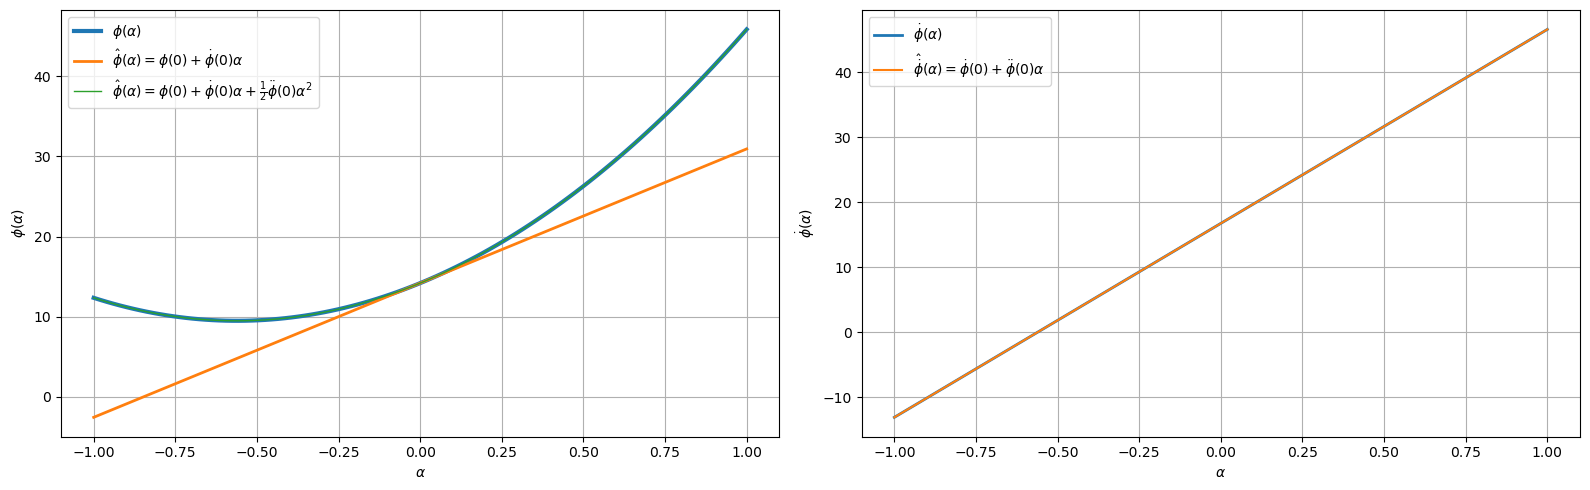

In [64]:
def test_function(p, alpha, x_vec):
    cost = h(p + alpha * x_vec)
    return 1 / 2 * np.linalg.norm(cost)**2

def test_function_grad(p, alpha, x_vec):
    cost = h(p + alpha * x_vec)
    jacobian = Dh(p + alpha * x_vec)
    return cost.T @ jacobian @ x_vec

def test_function_hessian(p, alpha, x_vec):
    o = 9
    n = len(x_vec)
    cost = h(p + alpha * x_vec)
    jacobian = Dh(p + alpha * x_vec)
    hessian = Hh(p + alpha * x_vec)
    # return cost.T @ np.einsum('ijk,k->ij', hessian.reshape((n, o, n)), x_vec.flatten()).T @ x_vec + x_vec.T @ jacobian.T @ jacobian @ x_vec # Which is also the same
    return cost.T @ np.kron(np.eye(o), x_vec).T @ hessian @ x_vec + x_vec.T @ jacobian.T @ jacobian @ x_vec

def test_function_approx_first_order(p, alpha, x_vec):
    return test_function(p, 0, x_vec) + test_function_grad(p, 0, x_vec) * alpha

def test_function_approx_second_order(p, alpha, x_vec):
    return test_function(p, 0, x_vec) + test_function_grad(p, 0, x_vec) * alpha + 1/2 * test_function_hessian(p, 0, x_vec) * alpha**2

def test_function_grad_approx_first_order(p, alpha, x_vec):
    return test_function_grad(p, 0, x_vec) + test_function_hessian(p, 0, x_vec) * alpha

std = 1e0
sample_x_vec = np.random.multivariate_normal(mean=np.zeros(24,), cov=std*np.eye(24)).reshape((24, 1))
p = np.random.multivariate_normal(mean=np.zeros(24,), cov=std*np.eye(24)).reshape((24, 1))

aux = 1e0
alpha_bounds = np.linspace(-aux, aux, 100)
cost_values = np.array([test_function(p, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
gradient_values = np.array([test_function_grad(p, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
hessian_values = np.array([test_function_hessian(p, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
taylor_series_first_order_expansion_test_function = np.array([test_function_approx_first_order(p, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
taylor_series_second_order_expansion_test_function = np.array([test_function_approx_second_order(p, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
taylor_series_first_order_expansion_test_function_grad = np.array([test_function_grad_approx_first_order(p, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])

# Arrows arrows
num_arrows = 30
arrow_indices = np.linspace(0, len(alpha_bounds) - 1, num_arrows, dtype=int)

def compute_tangent_slope(x, y, idx):
    """Compute the slope of the tangent line at a given index idx."""
    if idx == 0:
        slope = (y[idx + 1] - y[idx]) / (x[idx + 1] - x[idx])
    elif idx == len(x) - 1:
        slope = (y[idx] - y[idx - 1]) / (x[idx] - x[idx - 1])
    else:
        slope = (y[idx + 1] - y[idx - 1]) / (x[idx + 1] - x[idx - 1])

    return slope

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Left plot: Function and gradient arrows
axes[0].plot(alpha_bounds, cost_values, label=r'$\phi(\alpha)$', linewidth=3)
# axes[0].quiver(alpha_bounds[arrow_indices], cost_values[arrow_indices], 
#                np.ones_like(arrow_indices), gradient_values[arrow_indices], 
#                angles='xy', scale_units='xy', color='red', width=0.004, zorder=2, label=r'Analytical $\dot{\phi}(\alpha)$')
# axes[0].quiver(alpha_bounds[arrow_indices][1:], cost_values[arrow_indices][1:],
#                 np.ones_like(arrow_indices[1:]), np.array([compute_tangent_slope(alpha_bounds, cost_values, idx) for idx in arrow_indices])[1:],
#                 angles="xy", scale_units="xy", color="black", width=0.005, label=r'Numerical $\dot{\phi}(\alpha)$')
axes[0].plot(alpha_bounds, taylor_series_first_order_expansion_test_function, label=r'$\hat{\phi}(\alpha) = \phi(0) + \dot{\phi}(0)\alpha$', zorder=3, linewidth=2)
axes[0].plot(alpha_bounds, taylor_series_second_order_expansion_test_function, label=r'$\hat{\phi}(\alpha) = \phi(0) + \dot{\phi}(0)\alpha + \frac{1}{2}\ddot{\phi}(0)\alpha^2$', zorder=3, linewidth=1)
axes[0].set_xlabel(r'$\alpha$')
axes[0].set_ylabel(r'$\phi(\alpha)$')
axes[0].grid()
axes[0].legend()

# Right plot: Gradient and Hessian arrows
axes[1].plot(alpha_bounds, gradient_values, label=r'$\dot{\phi}(\alpha)$', linewidth=2)
# axes[1].quiver(alpha_bounds[arrow_indices], gradient_values[arrow_indices], 
#                np.ones_like(arrow_indices), hessian_values[arrow_indices], 
#                angles='xy', scale_units='xy', color='red', width=0.004, zorder=2, label=r'Analytical $\ddot{\phi}(\alpha)$')
# axes[1].quiver(alpha_bounds[arrow_indices][1:], gradient_values[arrow_indices][1:], 
#                np.ones_like(arrow_indices[1:]), np.array([compute_tangent_slope(alpha_bounds, gradient_values, idx) for idx in arrow_indices])[1:], 
#                angles="xy", scale_units="xy", color="black", width=0.005, label=r'Numerical $\ddot{\phi}(\alpha)$')
axes[1].plot(alpha_bounds, taylor_series_first_order_expansion_test_function_grad, label=r'$\hat{\dot{\phi}}(\alpha) = \dot{\phi}(0) + \ddot{\phi}(0)\alpha$', zorder=3)
axes[1].set_xlabel(r'$\alpha$')
axes[1].set_ylabel(r'$\dot{\phi}(\alpha)$')
axes[1].grid()
axes[1].legend()

plt.tight_layout()